# Omega Aragonite Escape Velocities (Tracking Shifting Contours)
# Surface k01

In [33]:
import xgcm
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature

In [34]:
%matplotlib inline

In [35]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

## RCP85 Ensemble Average

In [36]:
# k01 Omega Arag for ensemble average (preprocessed)
directory = '~/chazbpei2020/data/processed/Omega_Arag/RCP85/'
filename = 'omega_arag_k01_ensAvg_1950_2100.nc'
oa_path = directory+filename
ds = xr.open_dataset(oa_path).rename({'XT_OCEAN': 'xt_ocean',
                                     'YT_OCEAN': 'yt_ocean',
                                     'TIME': 'time',
                                     'OMEGA_ARAG': 'omega_arag'})

## Grid calculations

In [37]:
# default behavior is to extrapolite grid position to the left
ds_full = xgcm.generate_grid_ds(ds, {'X':'xt_ocean', 'Y':'yt_ocean'})

In [38]:
# Create grid object (periodic along X-axis)
grid = xgcm.Grid(ds_full, periodic=['X'], 
                 coords={'X': {'center': 'xt_ocean', 'left': 'xt_ocean_left'},
                         'Y': {'center': 'yt_ocean', 'left': 'yt_ocean_left'},
                         'T': {'center': 'time'}})

In [39]:
# Compute cartesian distances
grid_calculations(grid, ds_full)

---

## Decadal Mean Omega Arag

In [40]:
# Calculate the time-mean Omega Arag for 10 decades of simulation
# 2000s through 2090s labeled 0-9
da_oa_annual = ds_full.omega_arag.groupby('time.year').mean(dim='time', skipna=True)
da_oa_mean = []

decade = 2000
for i in range(10):
    dec_mean = decadal_mean(da_oa_annual, decade)
    da_oa_mean.append(dec_mean.squeeze())
    decade += 10

---

## Moving Omega Arag Contours during 21st Century

In [41]:
# Definte projection transformations and coordiantes
crs = ccrs.Robinson(central_longitude=180)
src=ccrs.PlateCarree()
lon = ds_full.xt_ocean.data
lat = ds_full.yt_ocean.data

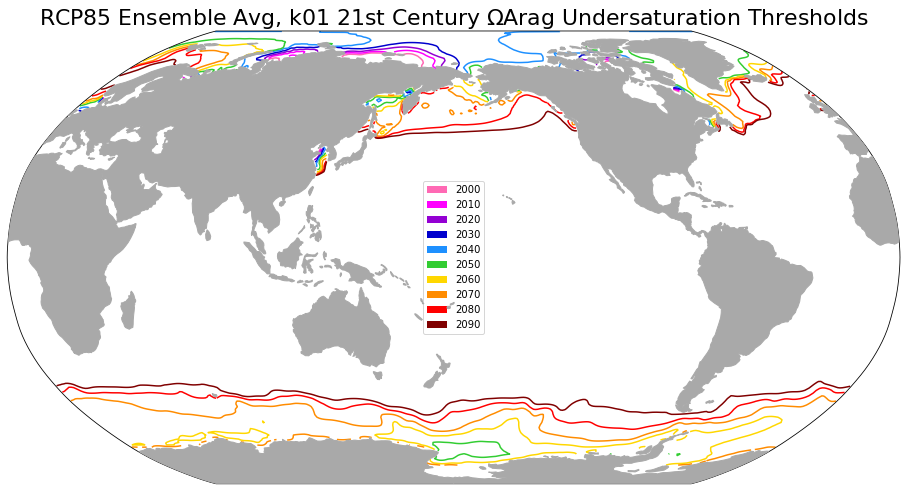

In [49]:
# Plot Velocities at undersaturation border for all decades
crs = ccrs.Robinson(central_longitude=180)
src=ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

# Create list of colors to plot contour for each decade
# colors = cm.get_cmap('plasma', 10)
colors = ['hotpink','magenta','darkviolet','mediumblue',
        'dodgerblue','limegreen','gold','darkorange',
          'red','maroon']
# Create levels array to isolate undersaturation threshold
clevs=[1]

decade=2000
num_decades=10
legend_elements = []
for i in range(num_decades):
    element = Patch(facecolor=colors[i], label=str(decade))
    legend_elements.append(element)
    decade+=10

for i in range(num_decades):
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[i],transform=src)
    
ax.legend(handles=legend_elements, loc='center')
ax.set_global()

ax.set_title('RCP85 Ensemble Avg, k01 21st Century $\Omega$Arag Undersaturation Thresholds',fontsize=22)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')

fig.savefig("./oa_escape_vel_figs/oa_k01_contours")

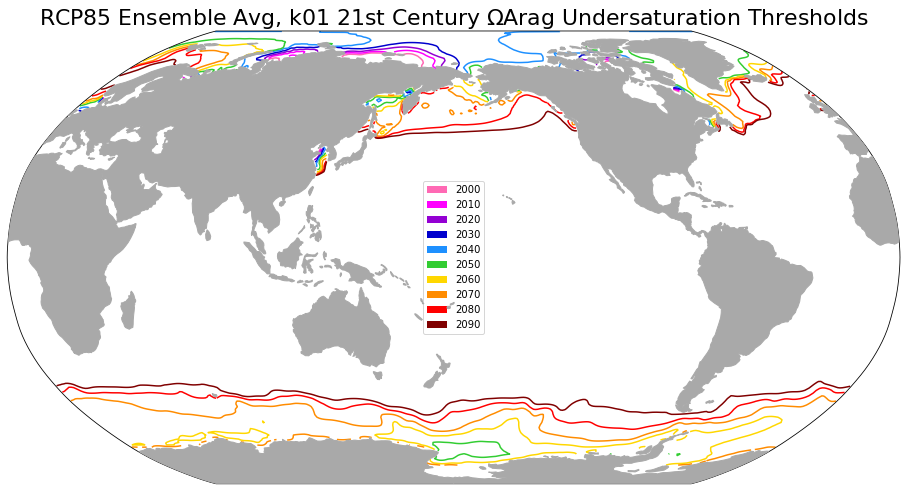

In [56]:
# Plot Velocities at undersaturation border for all decades
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

# Extract points from contour line segments for each decade
list_xpoints = []  # list contianing lists of x points for each decade
list_ypoints = []  # list contianing lists of y points for each decade
for i in range(num_decades):
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[i],transform=src)
    
    segments = cs.allsegs[0]
    num_segs = len(segments)
    
    xpoints = []  # to track multiple paths within same decade
    ypoints = []
    for j in range(num_segs):
        x = segments[j][:,0].tolist()  # convert to list to be easily concatenated
        y = segments[j][:,1].tolist()
        for p in x:
            xpoints.append(p)
        for p in y:
            ypoints.append(p)
    list_xpoints.append(xpoints)  # add list of x points for each decade
    list_ypoints.append(ypoints)  # add list of y points for each decade

ax.legend(handles=legend_elements, loc='center')
ax.set_global()

ax.set_title('RCP85 Ensemble Avg, k01 21st Century $\Omega$Arag Undersaturation Thresholds',fontsize=22)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')

---

## Calculations and Reformatting Data

In [44]:
# Round all values to nearest 0.5 (to be easily indexed)
# Create adjusted list to use later for indexing
list_xpoints_idx = []
list_ypoints_idx = []
for i in range(num_decades):  # list of lists
    xpoints = list_xpoints[i]  # individual list of xpoints
    ypoints = list_ypoints[i]  # individual list of ypoints
    num_points = len(xpoints)
    for p in range(num_points):
        xpoints[p] = round_half(xpoints[p])
        ypoints[p] = round_half(ypoints[p])
    xpoints = (np.array(xpoints)-0.5).tolist()
    ypoints = (np.array(ypoints)+89.5).tolist()

    list_xpoints_idx.append(xpoints)
    list_ypoints_idx.append(ypoints)

In [45]:
# For each contour, for 2000-2090, compute the minimum distance to 
# the contour of the next decade. i.e. for each x,y on the OA=1@2000 
# contour, find the closest OA=1@2010 contour.

# Create parallel arrays of list to hold lists of directions and vectors for each decade
list_vector_dx = []  # change in x for nearest points
list_vector_dy = []  # change in y for nearest points
list_vector_magnitude = []  # distance to nearest points

for i in range(num_decades-1):
    vector_dx = []  # change in x for decade
    vector_dy = []  # change in y for decade
    vector_magnitude = []  # vector magnitude for decade
    xpoints = list_xpoints[i]  # x coords for decade
    ypoints = list_ypoints[i]  # y coords for decade
    num_points = len(xpoints)
    # For each point, find min dist and closest point on contour 
    # of next decade
    for p in range(num_points):
        xp = xpoints[p]
        yp = ypoints[p]
        x,y,dx,dy,mindist = min_dist(xp,yp,
                                     list_xpoints[i+1],
                                     list_ypoints[i+1],
                                    da_oa_mean[i].data)
        # maintain lists of x and y vectors
        vector_dx.append(dx/1000)  # x component of dist
        vector_dy.append(dy/1000)  # y component of dist
        vector_magnitude.append(mindist/1000)  # dist magnitude
    
    list_vector_dx.append(vector_dx)
    list_vector_dy.append(vector_dy)
    list_vector_magnitude.append(vector_magnitude)

In [46]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

In [47]:
# Reformat data to be Mappable
nx = len(lon)
ny = len(lat)
da_escape_dist = []  # escape distances for each decade
da_escape_dx = []  # escape dx for each decade
da_escape_dy = []  # escape dy for each decade
# For each decade up to 2090s
for i in range(num_decades-1):
    # Create empty arrays and initialize all values to np.nan
    da_dx = np.zeros(shape=(nx,ny))
    da_dx[:,:] = np.nan
    da_dy = np.zeros(shape=(nx,ny))
    da_dy[:,:] = np.nan
    da_dist = np.zeros(shape=(nx,ny))
    da_dist[:,:] = np.nan
    # Iterate through points in adjusted array of contour points
    xpoints = list_xpoints_idx[i]
    ypoints = list_ypoints_idx[i]
    dx_vals = list_vector_dx[i]
    dy_vals = list_vector_dy[i]
    dist_vals = list_vector_magnitude[i]
    # For each contour point in the decade, save the escape vector
    # magnitude and direction in parallel DataArrays
    num_points = len(xpoints)
    for p in range(num_points):
        xp = int(xpoints[p])
        yp = int(ypoints[p])
        da_dx[xp,yp] = dx_vals[p]
        da_dy[xp,yp] = dy_vals[p]
        da_dist[xp,yp] = dist_vals[p]
        
    # Save out the vector (directionality and magnitude) fields as maps 
    # for each decade  
    da_dx = xr.DataArray(da_dx, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dx = da_dx.where(da_dx < np.inf)
    da_escape_dx.append(da_dx)
    da_dy = xr.DataArray(da_dy, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dy = da_dy.where(da_dy < np.inf)
    da_escape_dy.append(da_dy)
    da_dist = xr.DataArray(da_dist, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dist = da_dist.where(da_dist < np.inf)
    da_escape_dist.append(da_dist)

## Plot Escape Vectors for 21st Century

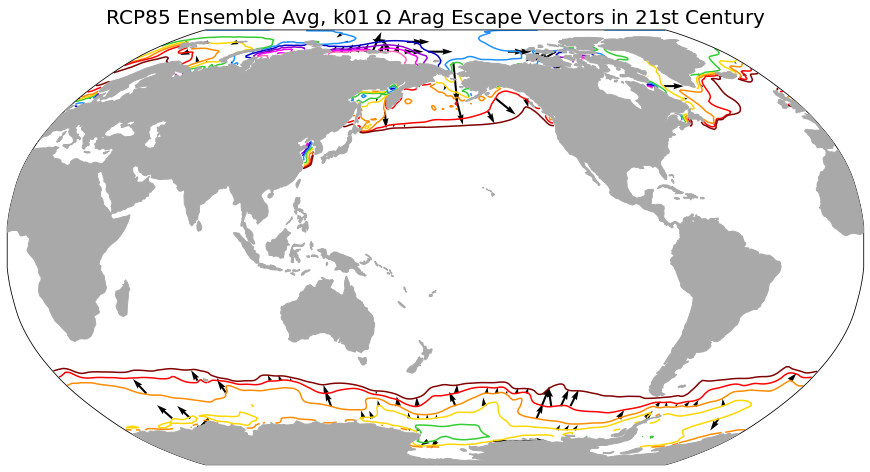

In [55]:
# Map escape vectors for any particular decade
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,8],
                               subplot_kw={'projection':crs})

# Create meshgrid for arrow plotting
X,Y = np.meshgrid(np.arange(360), np.arange(-90,90))
X = X+0.5
Y = Y+0.5
n=5

# For each decade except 2090s
for i in range(9):
#     i = i*2
    # Plot Omega Arag undersaturation contours for each decade
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[i],transform=src)
    
    # Plot escape vectors
    U = da_escape_dx[i].data
    V = da_escape_dy[i].data
#     Can normalize vectors to plot arrows of constant size
#     N = np.sqrt(U**2 + V**2)
#     U = U/N
#     V = V/N
    ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n], transform=src)

# Plot final decade contour 
cs = ax.contour(lon,lat,da_oa_mean[9],levels=clevs,
                    colors=colors[9],transform=src)

ax.set_title('RCP85 Ensemble Avg, k01 $\Omega$ Arag Escape Vectors in 21st Century',
             fontsize=20)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')

fig.savefig("./oa_escape_vel_figs/oa_k01_esc_vectors")